# OTTIMIZZAZIONE SLSQP

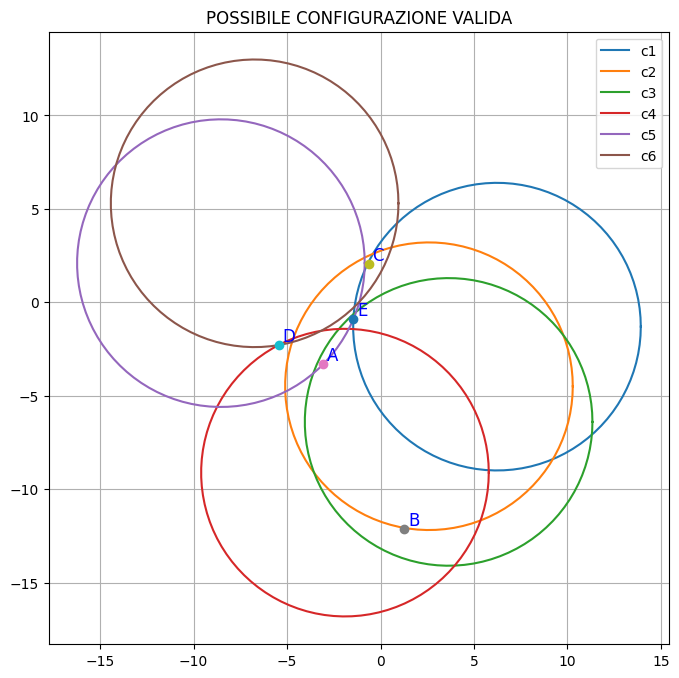

({'A': array([-3.09184327, -3.33011865]),
  'B': array([  1.26705001, -12.1532924 ]),
  'C': array([-0.6361434,  2.0351686]),
  'D': array([-5.45935781, -2.29391042]),
  'E': array([-1.45204822, -0.89973739])},
 {'c1': array([ 6.22974591, -1.30520357]),
  'c2': array([ 2.59012401, -4.49268309]),
  'c3': array([ 3.64274236, -6.4025001 ]),
  'c4': array([-1.9038951 , -9.11615916]),
  'c5': array([-8.54168019,  2.09255582]),
  'c6': array([-6.7373465 ,  5.29457814])},
 np.float64(7.695324544343479),
 True)

In [ ]:
# ============================================================================================================= #
# === CODICE DI COSTRUZIONE DEL GRAFICO ======================================================================= #
# ============================================================================================================= #



# === IMPORT DELLE LIBRERIE =================================================================================== #
# --- importiamo le librerie necessarie per costruire il grafico ---------------------------------------------- #
# ------------------------------------------------------------------------------------------------------------- #

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
# ------------------------------------------------------------------------------------------------------------- #



# === MATRICE E DATI ========================================================================================== #
# --- la  matrice sotto sotto forma di dizionario contiene le zone che sono effettivamente servite in 8 min. ---#
# --- definisco sotto points: come i punti che rappresentano le zone da raggiungere ----------------------------#
# --- definisco sotto centers: i punti dei centri dove verranno collocati gli eventuali vigili del fuoco -------#
# ------------------------------------------------------------------------------------------------------------- #

data = {
    "A": [0, 1, 1, 1, 1, 0],
    "B": [0, 0, 1, 1, 0, 0],
    "C": [1, 1, 0, 0, 0, 1],
    "D": [0, 0, 0, 1, 1, 1],
    "E": [1, 1, 1, 0, 1, 0]
}

points = list(data.keys())
centers = [f"c{i+1}" for i in range(6)]

num_points = len(points)
num_centers = len(centers)
# ------------------------------------------------------------------------------------------------------------- #



# === FUNZIONE unpack_variabiles(x) =========================================================================== #
# --- costruisce il vettore x che contiene le coordinate dei punti utilizzando lo stesso raggio per ogni C. ----#
# ------------------------------------------------------------------------------------------------------------- #

def unpack_variables(x):
    point_coords = x[:2*num_points].reshape((num_points, 2))
    center_coords = x[2*num_points:2*(num_points+num_centers)].reshape((num_centers, 2))
    r = x[-1]
    return point_coords, center_coords, r



# === F(x) OBBIETTIVO CON PENALITA' =========================================================================== #
# --- questa funzione obbiettivo è in grado di "provare" delle soluzioni assegnando delle penalità laddove -----#
# --- le variabili assumano comportamenti che si vogliano evitare (una sorta di vincoli!!!) --------------------#
# ------------------------------------------------------------------------------------------------------------- #

def objective(x):
    point_coords, center_coords, r = unpack_variables(x)
    penalty = 0.0

    # penalità per condizioni di inclusione/esclusione
    for i, point in enumerate(points):
        for j in range(num_centers):
            dx = point_coords[i][0] - center_coords[j][0]
            dy = point_coords[i][1] - center_coords[j][1]
            dist_sq = dx**2 + dy**2
            inside = data[point][j] == 1
            if inside:
                penalty += max(0, dist_sq - r**2)**2
            else:
                penalty += max(0, r**2 - dist_sq + 0.01)**2

    # penalità se due punti o due centri coincidono o sono troppo vicini
    for i in range(num_points):
        for j in range(i + 1, num_points):
            dist = np.linalg.norm(point_coords[i] - point_coords[j])
            penalty += 1000 * np.exp(-10 * dist**2)

    for i in range(num_centers):
        for j in range(i + 1, num_centers):
            dist = np.linalg.norm(center_coords[i] - center_coords[j])
            penalty += 1000 * np.exp(-10 * dist**2)

    return penalty
# ------------------------------------------------------------------------------------------------------------- #



# === INIZIALIZZAZIONE E OTTIMIZZAZIONE (SLSQP) =============================================================== #
# --- inizializziamo e ottimizziamo ponendo il vincolo che il raggio sia > 0 e non troppo piccolo ------------- #
# --- successivamente ottimizziamo cercando di minimizzare le penalità provando max 1000 iterazioni ----------- #
# ------------------------------------------------------------------------------------------------------------- #

# inizializzazione
np.random.seed(0)
x0 = np.random.uniform(-10, 10, size=2*(num_points + num_centers) + 1)
x0[-1] = 5.0  # raggio iniziale

constraints = [{'type': 'ineq', 'fun': lambda x: x[-1] - 0.1}]

# ottimizzazione
best_result = None
best_penalty = float('inf')

for i in range(10):  # n° tentativi
    x0 = np.random.uniform(-10, 10, size=2*(num_points + num_centers) + 1)
    x0[-1] = 5.0  # raggio iniziale

    result = minimize(objective, x0, method='SLSQP', constraints=constraints, options={'maxiter': 1000})

    if result.success:
        # controllo gli operatori logici
        point_coords, center_coords, r = unpack_variables(result.x)

        # continuo la validazione
        is_valid = True
        for i, point in enumerate(points):
            for j in range(num_centers):
                dx = point_coords[i][0] - center_coords[j][0]
                dy = point_coords[i][1] - center_coords[j][1]
                dist_sq = dx**2 + dy**2
                inside = data[point][j]
                if inside == 1 and dist_sq > r**2 + 1e-2:
                    is_valid = False
                if inside == 0 and dist_sq < r**2 - 1e-2:
                    is_valid = False

        if is_valid and result.fun < best_penalty:
            best_result = result
            best_penalty = result.fun
# ------------------------------------------------------------------------------------------------------------- #



# === ESTRAZIONI DATI E (RI)VERIFICA ========================================================================== #
# --- creo dei dizionari di raccolta che memorizzano punti, centri e relative coordinate ---------------------- #
# --- verifico successivamente che i dati rispettino tutti i vincoli ------------------------------------------ #
# --- N.B.: la funzione di minimizzazione di prima dava il risultato che minimizzava le panalizzazioni, ------- #
# --------- ma ciò non assicura che il risultato di minimizzazione sia effettivamente valido!!! --------------- #
# ------------------------------------------------------------------------------------------------------------- #

# raccolta dati
point_coords, center_coords, r = unpack_variables(result.x)
point_coords_dict = {points[i]: point_coords[i] for i in range(num_points)}
center_coords_dict = {centers[i]: center_coords[i] for i in range(num_centers)}

# funzione di verifica rispetto a tutti i vincoli
def validate_solution():
    for i, point in enumerate(points):
        for j in range(num_centers):
            dx = point_coords[i][0] - center_coords[j][0]
            dy = point_coords[i][1] - center_coords[j][1]
            dist_sq = dx**2 + dy**2
            inside = data[point][j]
            if inside == 1 and dist_sq > r**2 + 1e-2:
                return False
            if inside == 0 and dist_sq < r**2 - 1e-2:
                return False

    for i in range(num_points):
        for j in range(i + 1, num_points):
            dist = np.linalg.norm(point_coords[i] - point_coords[j])
            if dist < 0.1:
                return False
    for i in range(num_centers):
        for j in range(i + 1, num_centers):
            dist = np.linalg.norm(center_coords[i] - center_coords[j])
            if dist < 0.1:
                return False
    return True

valid_solution = validate_solution()
# ------------------------------------------------------------------------------------------------------------- #





# === DISEGNO DEL GRAFICO ===================================================================================== #
# --- disegno il grafico con i dati raccolti in precedenza (FINALMENTE!) ---------------------------------------#
# ------------------------------------------------------------------------------------------------------------- #
fig, ax = plt.subplots(figsize=(8, 8))
theta = np.linspace(0, 2*np.pi, 100)

# circonferenze
for i, c in enumerate(centers):
    cx, cy = center_coords_dict[c]
    ax.plot(cx + r * np.cos(theta), cy + r * np.sin(theta), label=c, linestyle='-')

# punti
for label, (x, y) in point_coords_dict.items():
    ax.plot(x, y, 'o')
    ax.text(x + 0.2, y + 0.2, label, fontsize=12, color='blue')

# impostazione grafica generale
ax.set_aspect('equal')
ax.grid(True)
ax.legend()
plt.title(f"POSSIBILE CONFIGURAZIONE {'VALIDA' if valid_solution else 'IMPOSSIBILE'}")
plt.show()

point_coords_dict, center_coords_dict, r, valid_solution


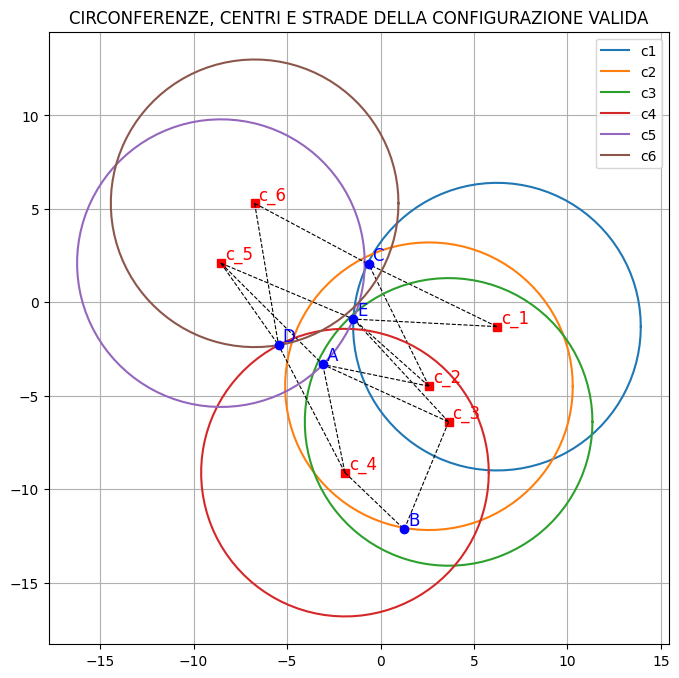

({'A': array([-3.09184327, -3.33011865]),
  'B': array([  1.26705001, -12.1532924 ]),
  'C': array([-0.6361434,  2.0351686]),
  'D': array([-5.45935781, -2.29391042]),
  'E': array([-1.45204822, -0.89973739])},
 {'c1': array([ 6.22974591, -1.30520357]),
  'c2': array([ 2.59012401, -4.49268309]),
  'c3': array([ 3.64274236, -6.4025001 ]),
  'c4': array([-1.9038951 , -9.11615916]),
  'c5': array([-8.54168019,  2.09255582]),
  'c6': array([-6.7373465 ,  5.29457814])},
 np.float64(7.695324544343479),
 True)

In [ ]:
# === GRFICO CON CENTRI E "STRADE" ============================================================================ #
# --- stessa struttura di sopra aggiungendo i centri delle circonferenze e i collegamenti con le zone --------- #
# ------------------------------------------------------------------------------------------------------------- #

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize


data = {
    "A": [0, 1, 1, 1, 1, 0],
    "B": [0, 0, 1, 1, 0, 0],
    "C": [1, 1, 0, 0, 0, 1],
    "D": [0, 0, 0, 1, 1, 1],
    "E": [1, 1, 1, 0, 1, 0]
}

points = list(data.keys())
centers = [f"c{i+1}" for i in range(6)]

num_points = len(points)
num_centers = len(centers)



def unpack_variables(x):
    point_coords = x[:2*num_points].reshape((num_points, 2))
    center_coords = x[2*num_points:2*(num_points+num_centers)].reshape((num_centers, 2))
    r = x[-1]
    return point_coords, center_coords, r

def objective(x):
    point_coords, center_coords, r = unpack_variables(x)
    penalty = 0.0


    for i, point in enumerate(points):
        for j in range(num_centers):
            dx = point_coords[i][0] - center_coords[j][0]
            dy = point_coords[i][1] - center_coords[j][1]
            dist_sq = dx**2 + dy**2
            inside = data[point][j] == 1
            if inside:
                penalty += max(0, dist_sq - r**2)**2
            else:
                penalty += max(0, r**2 - dist_sq + 0.01)**2


    for i in range(num_points):
        for j in range(i + 1, num_points):
            dist = np.linalg.norm(point_coords[i] - point_coords[j])
            penalty += 1000 * np.exp(-10 * dist**2)

    for i in range(num_centers):
        for j in range(i + 1, num_centers):
            dist = np.linalg.norm(center_coords[i] - center_coords[j])
            penalty += 1000 * np.exp(-10 * dist**2)

    return penalty



np.random.seed(0)
x0 = np.random.uniform(-10, 10, size=2*(num_points + num_centers) + 1)
x0[-1] = 5.0

constraints = [{'type': 'ineq', 'fun': lambda x: x[-1] - 0.1}]

best_result = None
best_penalty = float('inf')

for i in range(10):
    x0 = np.random.uniform(-10, 10, size=2*(num_points + num_centers) + 1)
    x0[-1] = 5.0

    result = minimize(objective, x0, method='SLSQP', constraints=constraints, options={'maxiter': 1000})

    if result.success:
        point_coords, center_coords, r = unpack_variables(result.x)

        is_valid = True
        for i, point in enumerate(points):
            for j in range(num_centers):
                dx = point_coords[i][0] - center_coords[j][0]
                dy = point_coords[i][1] - center_coords[j][1]
                dist_sq = dx**2 + dy**2
                inside = data[point][j]
                if inside == 1 and dist_sq > r**2 + 1e-2:
                    is_valid = False
                if inside == 0 and dist_sq < r**2 - 1e-2:
                    is_valid = False

        if is_valid and result.fun < best_penalty:
            best_result = result
            best_penalty = result.fun



point_coords, center_coords, r = unpack_variables(best_result.x)
point_coords_dict = {points[i]: point_coords[i] for i in range(num_points)}
center_coords_dict = {centers[i]: center_coords[i] for i in range(num_centers)}

def validate_solution():
    for i, point in enumerate(points):
        for j in range(num_centers):
            dx = point_coords[i][0] - center_coords[j][0]
            dy = point_coords[i][1] - center_coords[j][1]
            dist_sq = dx**2 + dy**2
            inside = data[point][j]
            if inside == 1 and dist_sq > r**2 + 1e-2:
                return False
            if inside == 0 and dist_sq < r**2 - 1e-2:
                return False

    for i in range(num_points):
        for j in range(i + 1, num_points):
            dist = np.linalg.norm(point_coords[i] - point_coords[j])
            if dist < 0.1:
                return False
    for i in range(num_centers):
        for j in range(i + 1, num_centers):
            dist = np.linalg.norm(center_coords[i] - center_coords[j])
            if dist < 0.1:
                return False
    return True

valid_solution = validate_solution()





fig, ax = plt.subplots(figsize=(8, 8))
theta = np.linspace(0, 2*np.pi, 100)

for i, c in enumerate(centers):
    cx, cy = center_coords_dict[c]
    ax.plot(cx + r * np.cos(theta), cy + r * np.sin(theta), label=c, linestyle='-')
    ax.plot(cx, cy, 's', color='red')
    ax.text(cx + 0.2, cy + 0.2, f'c_{i+1}', fontsize=12, color='red')

    for p_idx, point in enumerate(points):
        if data[point][i] == 1:
            px, py = point_coords_dict[point]
            ax.plot([cx, px], [cy, py], 'k--', linewidth=0.8)

for label, (x, y) in point_coords_dict.items():
    ax.plot(x, y, 'o', color='blue')
    ax.text(x + 0.2, y + 0.2, label, fontsize=12, color='blue')

ax.set_aspect('equal')
ax.grid(True)
ax.legend()
plt.title(f"CIRCONFERENZE, CENTRI E STRADE DELLA CONFIGURAZIONE {'VALIDA' if valid_solution else 'IMPOSSIBILE'}")
plt.show()

point_coords_dict, center_coords_dict, r, valid_solution


<ipython-input-6-409545d0959f>:155: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


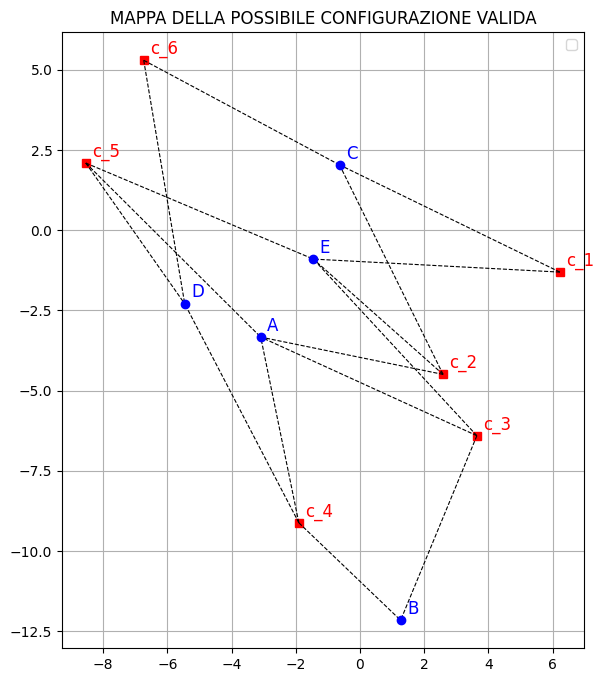

({'A': array([-3.09184327, -3.33011865]),
  'B': array([  1.26705001, -12.1532924 ]),
  'C': array([-0.6361434,  2.0351686]),
  'D': array([-5.45935781, -2.29391042]),
  'E': array([-1.45204822, -0.89973739])},
 {'c1': array([ 6.22974591, -1.30520357]),
  'c2': array([ 2.59012401, -4.49268309]),
  'c3': array([ 3.64274236, -6.4025001 ]),
  'c4': array([-1.9038951 , -9.11615916]),
  'c5': array([-8.54168019,  2.09255582]),
  'c6': array([-6.7373465 ,  5.29457814])},
 np.float64(7.695324544343479),
 True)

In [ ]:
# === GRFICO SENZA CIRCONFERENZA ============================================================================== #
# --- elimino le circonferenze che sono state utili solo per la costruzione di questa mappa ------------------- #
# ------------------------------------------------------------------------------------------------------------- #

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

data = {
    "A": [0, 1, 1, 1, 1, 0],
    "B": [0, 0, 1, 1, 0, 0],
    "C": [1, 1, 0, 0, 0, 1],
    "D": [0, 0, 0, 1, 1, 1],
    "E": [1, 1, 1, 0, 1, 0]
}

points = list(data.keys())
centers = [f"c{i+1}" for i in range(6)]

num_points = len(points)
num_centers = len(centers)



def unpack_variables(x):
    point_coords = x[:2*num_points].reshape((num_points, 2))
    center_coords = x[2*num_points:2*(num_points+num_centers)].reshape((num_centers, 2))
    r = x[-1]
    return point_coords, center_coords, r

def objective(x):
    point_coords, center_coords, r = unpack_variables(x)
    penalty = 0.0

    for i, point in enumerate(points):
        for j in range(num_centers):
            dx = point_coords[i][0] - center_coords[j][0]
            dy = point_coords[i][1] - center_coords[j][1]
            dist_sq = dx**2 + dy**2
            inside = data[point][j] == 1
            if inside:
                penalty += max(0, dist_sq - r**2)**2
            else:
                penalty += max(0, r**2 - dist_sq + 0.01)**2

    for i in range(num_points):
        for j in range(i + 1, num_points):
            dist = np.linalg.norm(point_coords[i] - point_coords[j])
            penalty += 1000 * np.exp(-10 * dist**2)

    for i in range(num_centers):
        for j in range(i + 1, num_centers):
            dist = np.linalg.norm(center_coords[i] - center_coords[j])
            penalty += 1000 * np.exp(-10 * dist**2)

    return penalty



np.random.seed(0)
x0 = np.random.uniform(-10, 10, size=2*(num_points + num_centers) + 1)
x0[-1] = 5.0

constraints = [{'type': 'ineq', 'fun': lambda x: x[-1] - 0.1}]



best_result = None
best_penalty = float('inf')

for i in range(10):
    x0 = np.random.uniform(-10, 10, size=2*(num_points + num_centers) + 1)
    x0[-1] = 5.0

    result = minimize(objective, x0, method='SLSQP', constraints=constraints, options={'maxiter': 1000})

    if result.success:
        point_coords, center_coords, r = unpack_variables(result.x)

        is_valid = True
        for i, point in enumerate(points):
            for j in range(num_centers):
                dx = point_coords[i][0] - center_coords[j][0]
                dy = point_coords[i][1] - center_coords[j][1]
                dist_sq = dx**2 + dy**2
                inside = data[point][j]
                if inside == 1 and dist_sq > r**2 + 1e-2:
                    is_valid = False
                if inside == 0 and dist_sq < r**2 - 1e-2:
                    is_valid = False

        if is_valid and result.fun < best_penalty:
            best_result = result
            best_penalty = result.fun


point_coords, center_coords, r = unpack_variables(best_result.x)
point_coords_dict = {points[i]: point_coords[i] for i in range(num_points)}
center_coords_dict = {centers[i]: center_coords[i] for i in range(num_centers)}



def validate_solution():
    for i, point in enumerate(points):
        for j in range(num_centers):
            dx = point_coords[i][0] - center_coords[j][0]
            dy = point_coords[i][1] - center_coords[j][1]
            dist_sq = dx**2 + dy**2
            inside = data[point][j]
            if inside == 1 and dist_sq > r**2 + 1e-2:
                return False
            if inside == 0 and dist_sq < r**2 - 1e-2:
                return False

    for i in range(num_points):
        for j in range(i + 1, num_points):
            dist = np.linalg.norm(point_coords[i] - point_coords[j])
            if dist < 0.1:
                return False
    for i in range(num_centers):
        for j in range(i + 1, num_centers):
            dist = np.linalg.norm(center_coords[i] - center_coords[j])
            if dist < 0.1:
                return False
    return True

valid_solution = validate_solution()





fig, ax = plt.subplots(figsize=(8, 8))
theta = np.linspace(0, 2*np.pi, 100)

for i, c in enumerate(centers):
    cx, cy = center_coords_dict[c]

    ax.plot(cx, cy, 's', color='red')
    ax.text(cx + 0.2, cy + 0.2, f'c_{i+1}', fontsize=12, color='red')

    for p_idx, point in enumerate(points):
        if data[point][i] == 1:
            px, py = point_coords_dict[point]
            ax.plot([cx, px], [cy, py], 'k--', linewidth=0.8)



for label, (x, y) in point_coords_dict.items():
    ax.plot(x, y, 'o', color='blue')
    ax.text(x + 0.2, y + 0.2, label, fontsize=12, color='blue')

ax.set_aspect('equal')
ax.grid(True)
ax.legend()
plt.title(f"MAPPA DELLA POSSIBILE CONFIGURAZIONE {'VALIDA' if valid_solution else 'IMPOSSIBILE'}")
plt.show()

point_coords_dict, center_coords_dict, r, valid_solution
